<a href="https://colab.research.google.com/github/yellowflickerbeat/EXXA_tests/blob/main/gt_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install astropy scikit-learn umap-learn tensorflow tqdm

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

import tensorflow as tf
from tensorflow.keras import layers, models

In [26]:
#Load files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
DATA_PATH = "/content/drive/MyDrive/exxa_25/*.fits"

files = sorted(glob(DATA_PATH))
print("Total files:", len(files))

Total files: 150


In [28]:
images = []

for f in files:
    with fits.open(f) as hdul:
        data = hdul[0].data          # could be (4,600,600) or (1,1,600,600)
        img = np.squeeze(data)[0]    # force → (600,600)
        images.append(img)

images = np.stack(images)
print(images.shape)


(150, 600, 600)


In [29]:
# Normalize (safe)
max_vals = np.max(images, axis=(1,2), keepdims=True)
max_vals[max_vals == 0] = 1.0
images = images / max_vals

# Downsample
images = images[:, ::4, ::4]

# Add channel dim ONCE
images = images[..., np.newaxis]
print(images.shape)

(150, 150, 150, 1)


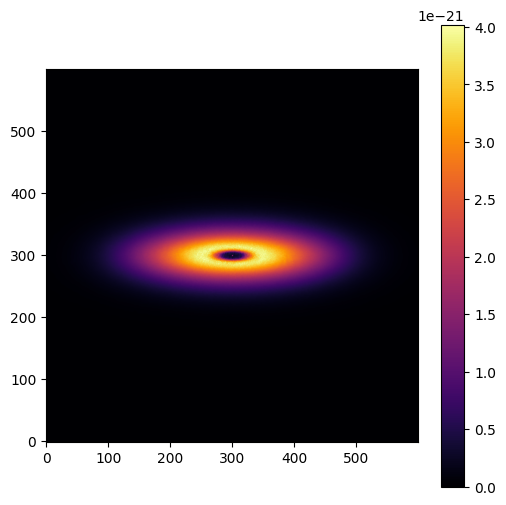

In [30]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Path to ONE fits file
fits_path = "/content/drive/MyDrive/exxa_25/planet86_00414_1250.fits"

# Open and extract image
with fits.open(fits_path) as hdul:
    data = hdul[0].data
    img = np.squeeze(data)[0]   # first physical layer

# Display
plt.figure(figsize=(6,6))
plt.imshow(img, origin="lower", cmap="inferno")
plt.colorbar()
plt.show()

In [39]:
latent_dim = 32

encoder = models.Sequential([
    layers.Input(shape=(150,150,1)),
    layers.Conv2D(16, 3, activation='relu', strides=2, padding='same'),
    layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
    layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(latent_dim)
])

decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(19*19*64, activation='relu'),
    layers.Reshape((19,19,64)),

    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),

    #  force exact spatial size
    layers.Cropping2D(((1,1), (1,1))),   # 152 → 150

    layers.Conv2D(1, 3, activation='sigmoid', padding='same')
])

input_img = layers.Input(shape=(150,150,1))

latent = encoder(input_img)
reconstructed = decoder(latent)

autoencoder = models.Model(input_img, reconstructed)


autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 32)             │       762,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 150, 150, 1)    │       822,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,585,249 (6.05 MB)

 Trainable params: 1,585,249 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
print(images.shape)
assert images.ndim == 4
assert images.shape[-1] == 1
assert not np.isnan(images).any()


(150, 150, 150, 1)


In [41]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

In [ ]:
history = autoencoder.fit(
    images, images,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    shuffle=True,
    verbose=1
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - loss: 0.2256 - val_loss: 0.1920
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step - loss: 0.2140 - val_loss: 0.1754
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - loss: 0.1904 - val_loss: 0.0948
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - loss: 0.0594 - val_loss: 0.0198
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - loss: 0.0099 - val_loss: 0.0198
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - loss: 0.0113 - val_loss: 0.0194
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 583ms/step - loss: 0.0108 - val_loss: 0.0192
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - loss: 0.0118 - val_loss: 0.0192
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step - loss: 0.0102 - val_loss: 0.0192
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step - loss: 0.0117 - val_loss: 0.0192
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - loss: 0.0127 - val_loss: 0.0190
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - loss: 0.0130 - val_l